In [1]:
!pip install xee geemap rioxarray

import ee
import geemap
import xarray as xr
import xee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray

# Authenticate Earth Engine
ee.Authenticate()
ee.Initialize(project='air-quality-466614', opt_url='https://earthengine-highvolume.googleapis.com')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [19]:
gaul = (ee.FeatureCollection("FAO/GAUL/2015/level2")
        .filter(ee.Filter.eq('ADM0_NAME', 'Sri Lanka')))

roi = gaul.geometry()

In [20]:
monthly_data = (ee.ImageCollection("projects/sat-io/open-datasets/GHAP/GHAP_M1K_PM25").filterDate('2017','2023'))

monthly_dataset=xr.open_dataset(monthly_data,
                                engine='ee',
                                crs='EPSG:4326',
                                geometry=roi,
                                scale=0.001
                                )

In [21]:
monthly_avg=monthly_dataset.mean(dim=['lat','lon'])*0.1

In [22]:
monthly_df=monthly_avg.to_dataframe()

In [30]:
df=monthly_df

In [31]:
df

,b1
time,
2017-01-01,1.937446
2017-02-01,1.924218
2017-03-01,1.826053
2017-04-01,2.519459
2017-05-01,1.591298
...,...
2022-08-01,0.938866
2022-09-01,1.041171
2022-10-01,1.342296


In [27]:
df.count()

,0
b1,72


Available columns: ['b1']
Column 'time' not found. Available columns: ['b1']


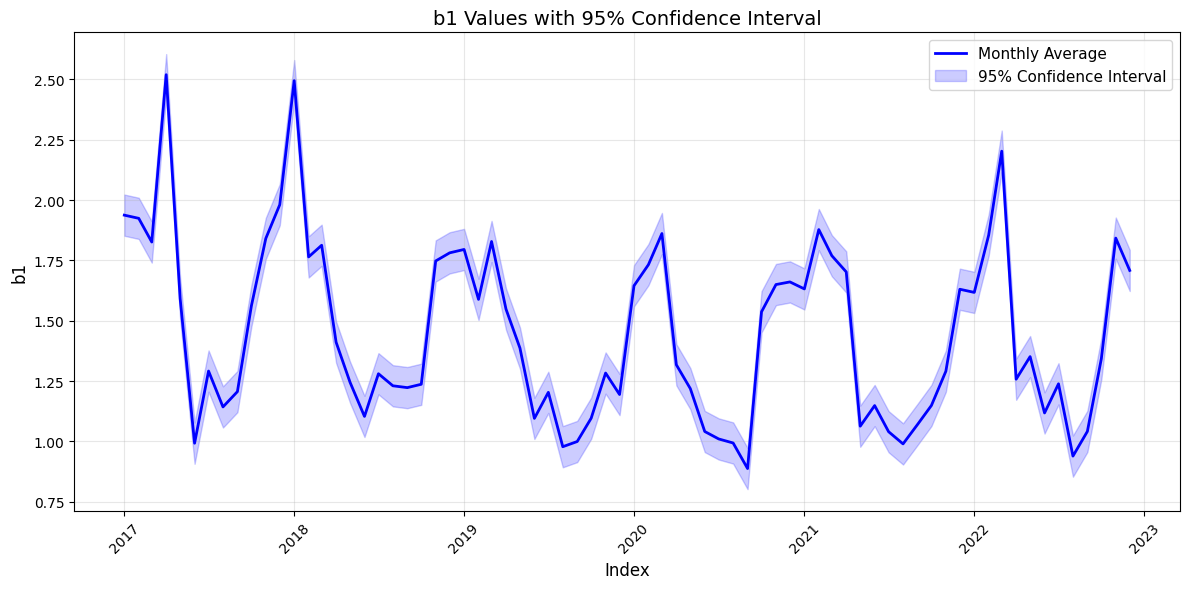

Average b1 value: 1.452
Standard deviation: 0.370
Confidence interval width: ±0.085


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Check what your actual column names are
print("Available columns:", df.columns.tolist())

# Replace 'time' and 'b1' with your actual column names
# For example, if your columns are named 'date' and 'value':
time_column = 'time'  # Change this to your actual time column name
value_column = 'b1'   # Change this to your actual value column name

# Check if the columns exist
if time_column not in df.columns:
    print(f"Column '{time_column}' not found. Available columns: {df.columns.tolist()}")
    # If no time column, use index as x-axis
    time_points = df.index
    time_label = 'Index'
else:
    time_points = df[time_column]
    time_label = time_column

if value_column not in df.columns:
    print(f"Column '{value_column}' not found. Available columns: {df.columns.tolist()}")
    # Use first numeric column if 'b1' doesn't exist
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    if len(numeric_columns) > 0:
        value_column = numeric_columns[0]
        print(f"Using '{value_column}' as value column")
    else:
        raise ValueError("No numeric columns found in DataFrame")

mean_values = df[value_column].values

# Calculate a reasonable CI based on the overall variability of your data
data_std = np.std(mean_values)  # Standard deviation of the means
n = 72  # Your sample size

# Calculate 95% confidence interval
standard_error = data_std / np.sqrt(n)
critical_value = 1.96  # For 95% CI with large sample size

# Create CI for each point
lower_ci = mean_values - critical_value * standard_error
upper_ci = mean_values + critical_value * standard_error

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_points, mean_values, label='Monthly Average', color='blue', linewidth=2)

# Fill between for confidence interval
plt.fill_between(time_points, lower_ci, upper_ci, color='blue', alpha=0.2,
                 label='95% Confidence Interval')

# Customize the plot
plt.xlabel(time_label, fontsize=12)
plt.ylabel(value_column, fontsize=12)
plt.title(f'{value_column} Values with 95% Confidence Interval', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels only if they are dates/strings
if not isinstance(time_points, pd.RangeIndex):
    plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()
plt.show()

print(f"Average {value_column} value: {np.mean(mean_values):.3f}")
print(f"Standard deviation: {data_std:.3f}")
print(f"Confidence interval width: ±{(np.mean(upper_ci - lower_ci)/2):.3f}")